##### Import required libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import norm,geom
import math
from matplotlib import pyplot as plt
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import seaborn as sns
import random
from scipy.interpolate import interp1d
from matplotlib.backends.backend_pdf import PdfPages  

##### Import the master data containing the age, gender and Service Type

In [2]:
master_data = pd.read_csv('C:\Raha\Work\TEMPOS\Dr.Tighe\ENCRYPTED_MASTER_DATASET.csv')
#master_data = pd.read_csv('/Volumes/Tempos/TEMPOS Release 1_11_17/CSV/ENCRYPTED_MASTER_DATASET.csv')

filtered_master=master_data
filtered_master['Age']=''
filtered_master.loc[filtered_master['Age at Encounter'] <= 40, 'Age'] = '40 and Below'
filtered_master.loc[((filtered_master['Age at Encounter'] >=40) & (filtered_master['Age at Encounter'] <=70)), 'Age'] = 'Between 40 and 70'
filtered_master.loc[((filtered_master['Age at Encounter'] >=70)) , 'Age'] = 'Above 70'
filtered=filtered_master[['RedCap_ID','Age','Sex','Service']]

### Extract Engineering Logs

The aim of the code is to extract  the demands and deliveries according and analyze the distributions.
First all the required libraries are imported. The data is extracted from the Engineering logs.
The variables used stand for the following:
keypress-list of  the number of keypresses (demands) per patient.

doses-list of the number of deliveries per patient.

patient-list of patient id

time_demand-Time between demands

time_delivery-Time between deliveries

last_demand-Time to the last demand per patient

last_delivery-Time to the last delivery per patient

In [148]:
import os
rootdir = 'C:\Raha\Work\TEMPOS\Dr.Tighe\PCA Logs 1_20_17'
#rootdir = '/Volumes/Tempos/PCA Logs 1_20_17'
keypress=[]
doses=[]
patient=[]
patient_id=[]
time_demand=[]
demand_hr=[]
delivery_hr=[]
demand_72=[]
doses_72=[]
time_delivery=[]
person_dmd=[]
person_del=[]
last_demand=[]
last_delivery=[]
tries=[]
tm=[]
preprocessed = pd.DataFrame()
gender=[]
age=[]
service=[]
time_delivery_df = pd.DataFrame()
time_demand_df = pd.DataFrame()
df_demands=pd.DataFrame()
for subdir, dirs, files in os.walk(rootdir):
    for file in files:      
        try:
            #Extract the excel and create  the dataframe 
            xl = pd.ExcelFile(os.path.join(subdir, file)
                 ,skiprows=5,parse_cols="A,B,C,F" )
            sheet_name=xl.sheet_names[0]
            df = xl.parse(sheet_name,skiprows=4,parse_cols="A,B,C,F")

            #file name is RedCap_ID of the patient
            patient_id=subdir.split("\\")[6]
            #Extract the Gender, Age and Service Type
            temp=filtered[filtered.RedCap_ID==patient_id]
            xtract = pd.concat([xtract, temp])
            #Shifting the columns to get the keypress events followed by program complete event (Demand followed by delivery)
            df['shiftDown']=''
            shiftDownDf=df[0:len(df)-1][['Description']]
            dfnew=pd.DataFrame({1:0},index=[0])
            shiftDownDf=pd.concat([dfnew,shiftDownDf]).reset_index(drop=True)
            df['shiftDown']=shiftDownDf['Description']
            #extract all the demands (signified by keypress event)
            filtered_demand=df[df.Description=='KEYPRESS_ATTACHED']
            filtered_demand=filtered_demand.sort_values('Log Date')
            tt=pd.DataFrame(pd.to_datetime(filtered_demand['Log Date'])-pd.to_datetime(filtered_demand[['Log Date']].iloc[0][0])).astype('timedelta64[s]')
            filtered_demand.loc[:,'nextTimeDiff']=tt.loc[:,'Log Date']
            new_df=filtered_demand[['nextTimeDiff']]
            new_df['Id']=patient_id
            df_demands=df_demands.append(new_df)
            shiftUpDf=filtered_demand[1:len(filtered_demand)][['nextTimeDiff']]
            filtered_demand=filtered_demand.reset_index(drop=True)
            shiftUpDf=shiftUpDf.reset_index(drop=True)
            filtered_demand['shiftUp']=shiftUpDf
            dmd=filtered_demand['shiftUp']-filtered_demand['nextTimeDiff'][0:-2]
            dmd=np.array(dmd)
            dmd=dmd[~np.isnan(dmd)]
            avg_dmd=sum(dmd)/len(dmd)
            person_dmd.append(avg_dmd)
            demand_72.append(len(filtered_demand[filtered_demand['nextTimeDiff']/(60*60)<=72]))

            #Time between demands
            time_demand.extend(filtered_demand['shiftUp']-filtered_demand['nextTimeDiff'][0:-2])
            #Time until last demand.For Kaplan Meier plots
            last_demand.append(filtered_demand['nextTimeDiff'][len(filtered_demand)-1])
            #Demand per hour
            demand_hr.extend(filtered_demand['nextTimeDiff'])

            #extract all the deliveries (signified by PROGRAM_COMPLETE_ATTACHED event)
            filtered_delivery=df[(df.Description=='KEYPRESS_ATTACHED') & (df.shiftDown=='PROGRAM_COMPLETE_ATTACHED') ]
            filtered_delivery=filtered_delivery.sort_values('Log Date')
            filtered_delivery['timeDiff']=pd.DataFrame(pd.to_datetime(filtered_delivery['Log Date'])-pd.to_datetime(filtered_delivery[['Log Date']].iloc[0][0])).astype('timedelta64[s]')
            probtime_delivery=filtered_delivery[1:len(filtered_delivery)][['timeDiff']]
            filtered_delivery=filtered_delivery.reset_index(drop=True)
            probtime_delivery=probtime_delivery.reset_index(drop=True)
            filtered_delivery['time_delivery']=probtime_delivery
            #Records the last delivery time. For Kaplan Meier plots
            last_delivery.append(filtered_delivery['timeDiff'][len(filtered_delivery)-1])
            delivery=filtered_delivery['time_delivery']-filtered_delivery['timeDiff']
            delivery=np.array(delivery)
            delivery=delivery[~np.isnan(delivery)]
            avg_del=sum(delivery)/len(delivery)
            person_del.append(avg_del)
            
            #Time between delivery
            time_delivery.extend(filtered_delivery['time_delivery']-filtered_delivery['timeDiff'])

            if not xtract.empty :
                age.append(xtract['Age'].tolist()[0])
                gender.append(xtract['Sex'].tolist()[0])
                service.append(xtract['Service'].tolist()[0])
                td=pd.DataFrame(filtered_demand['shiftUp']-filtered_demand['nextTimeDiff'][0:-2])
                td['Sex']=xtract['Sex'].tolist()[0]
                td['Age']=xtract['Age'].tolist()[0]
                td['Service']=xtract['Service'].tolist()[0]
                time_demand_df=time_demand_df.append(td)
                td=pd.DataFrame(filtered_delivery['time_delivery']-filtered_delivery['timeDiff'])
                td['Sex']=xtract['Sex'].tolist()[0]
                td['Age']=xtract['Age'].tolist()[0]
                td['Service']=xtract['Service'].tolist()[0]
                time_delivery_df=time_delivery_df.append(td,ignore_index=True)
            else :
                age.append('')
                gender.append('')
                service.append('') 
            delivery_hr.extend(filtered_delivery['timeDiff'])
            
            #Records the number of demands
            keypress.append(len(filtered_demand))
            #Records the number of deliveries
            doses.append(len(filtered_delivery))

            #Number of doses in the first 72 hours
            doses_72.append(len(filtered_delivery[filtered_delivery['timeDiff']/(60*60)<=72]))
            #List of patients
            patient.append(patient_id)

            #To find out after how many demands ,there was a successful delivery
            filtered_demand['TemposId']=patient_id
            filtered_demand['flag']=0
            filtered_demand.loc[filtered_demand['Log Date'].isin(filtered_delivery['Log Date'].tolist()) , 'flag'] = 1
            idx=filtered_demand[filtered_demand.flag==1].index.tolist()[0]-filtered_demand.index.tolist()[0]
            tries.append(idx+1)

            #Finding out after how many seconds after the first demand ,there was a successful delivery
            date_tm=filtered_demand.ix[idx]['Log Date']
            tm.append(pd.to_datetime(date_tm)-pd.to_datetime(filtered_demand[['Log Date']].iloc[0][0]))
            preprocessed=preprocessed.append(filtered_demand[['TemposId','Log Date','flag']],ignore_index=True)

        except:
            print("Error")



Error
WARNING *** file size (271633) not 512 + multiple of sector size (512)
Error
Error


C:\Users\BME-LADM-Baharloo\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\BME-LADM-Baharloo\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:130: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


WARNING *** file size (258785) not 512 + multiple of sector size (512)
Error
Error
WARNING *** file size (337023) not 512 + multiple of sector size (512)
Error
WARNING *** file size (128165) not 512 + multiple of sector size (512)
WARNING *** file size (271005) not 512 + multiple of sector size (512)
WARNING *** file size (1400407) not 512 + multiple of sector size (512)
Error
Error
WARNING *** file size (251137) not 512 + multiple of sector size (512)
WARNING *** file size (2309840) not 512 + multiple of sector size (512)
Error
WARNING *** file size (327525) not 512 + multiple of sector size (512)
WARNING *** file size (2179649) not 512 + multiple of sector size (512)
Error
WARNING *** file size (55753) not 512 + multiple of sector size (512)
Error
Error
WARNING *** file size (267823) not 512 + multiple of sector size (512)
WARNING *** file size (2004124) not 512 + multiple of sector size (512)
Error
WARNING *** file size (263847) not 512 + multiple of sector size (512)
Error
WARNING 

##### Removing outliers

In [151]:
last_demand.remove(520327096.0)

In [152]:
time_demand.remove(519191369.0)

In [157]:
df_prep=pd.DataFrame()
df_prep['id']=patient
df_prep['k']=tries
df_prep['Time']=pd.DataFrame(tm).astype('timedelta64[s]')
df_prep=df_prep[df_prep['id']!='TEMPOS-68']
df_prep['Time_mod']=df_prep['Time']
for i, row in df_prep.iterrows():
    val = row['Time']
    if val==0.0:
        val = random.random()
        df_prep.set_value(i,'Time_mod',val)
df_prep[['id','k']].to_csv('C:\Raha\Work\TEMPOS\Dr.Tighe\\trials.csv',index=False)
df_prep[['id','Time']].to_csv('C:\Raha\Work\TEMPOS\Dr.Tighe\\expTime.csv',index=False)
df_prep[['id','Time_mod']].to_csv('C:\Raha\Work\TEMPOS\Dr.Tighe\\expTime_mod.csv',index=False)

###  Extract gender,service age information

### DISTRIBUTION OF GENDER,SERVICE AND AGE

In the first part, the distribution of demands and deliveries for gender, age and service has been generated .This is followed by the scatter plot of the data 

In [158]:
master_data = pd.read_csv('C:\Raha\Work\TEMPOS\Dr.Tighe\ENCRYPTED_MASTER_DATASET.csv')

In [159]:
filtered_master=master_data[master_data['RedCap_ID'].isin (patient)]

In [160]:
combined= pd.DataFrame({'RedCap_ID': patient,
     'Doses': doses,
     'Keypress': keypress
    })

In [161]:
combined_72= pd.DataFrame({'RedCap_ID': patient,
     'Doses': doses_72,
     'Demand': demand_72
    })

In [162]:
mrg=pd.merge(combined_72, filtered_master, on='RedCap_ID')
mrg['Age']=''
mrg.loc[mrg['Age at Encounter'] <= 40, 'Age'] = '40 and Below'
mrg.loc[((mrg['Age at Encounter'] >=40) & (mrg['Age at Encounter'] <=70)), 'Age'] = '70 and Below'
mrg.loc[((mrg['Age at Encounter'] >=70)) , 'Age'] = 'Above 70'

In [163]:
mrg=mrg[['RedCap_ID','Doses','Demand','Service','Age','Sex']]

In [164]:
mrg.groupby('Sex').sum()

,Doses,Demand
Sex,,
FEMALE,392,619
MALE,409,673


In [165]:
mrg.groupby('Age').sum()

,Doses,Demand
Age,,
40 and Below,122,186
70 and Below,367,596
Above 70,312,510


In [166]:
mrg.groupby('Service').sum()

,Doses,Demand
Service,,
Colorectal Surgery,92,107
Neurosurgery,51,148
Pancreas & Biliary Surgery,171,283
Thoracic/Cardiovascular Surgery,305,431
Urology,182,323


In [167]:
merged_df=pd.merge(combined, filtered_master, on='RedCap_ID')

In [168]:
x=merged_df['Service'].tolist()
y=merged_df['Keypress'].tolist()


In [169]:
service_df=merged_df[['Service','Keypress']]

In [170]:
merged_df.columns
sns.set_style("whitegrid")

### Surgical Service 

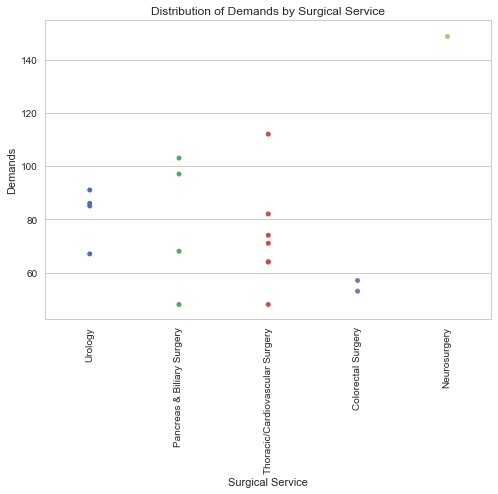

In [171]:
g=sns.stripplot(x='Service', y='Keypress', data=service_df);

plt.xticks(rotation=90)
g.set(xlabel='Surgical Service', ylabel='Demands')
sns.plt.title('Distribution of Demands by Surgical Service')
f=g.get_figure()
pp = PdfPages('SurgicalService.pdf')
pp.savefig(f,bbox_inches='tight')
pp.close()

### Gender

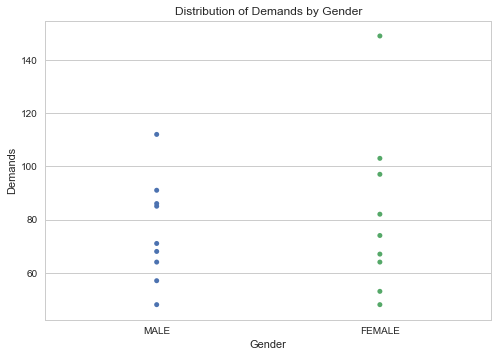

In [172]:
g=sns.stripplot(x='Sex', y='Keypress', data=merged_df);
g.set(xlabel='Gender', ylabel='Demands')
sns.plt.title('Distribution of Demands by Gender')
f=g.get_figure()
pp = PdfPages('Gender.pdf')
pp.savefig(f,bbox_inches='tight')
pp.close()

### Age

In [173]:
merged_df['Age']=''
merged_df.loc[merged_df['Age at Encounter'] <= 40, 'Age'] = '40 and Below'
merged_df.loc[((merged_df['Age at Encounter'] >=40) & (merged_df['Age at Encounter'] <=70)), 'Age'] = '70 and Below'
merged_df.loc[((merged_df['Age at Encounter'] >=70)) , 'Age'] = 'Above 70'

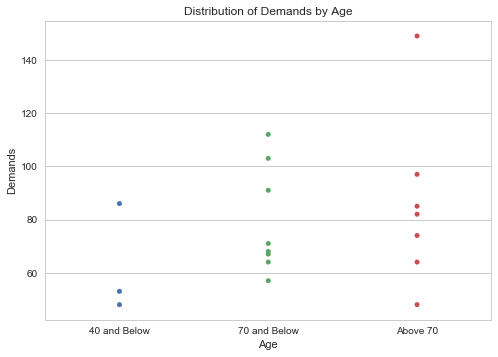

In [174]:
g=sns.stripplot(x='Age', y='Keypress', data=merged_df);
g.set(xlabel='Age', ylabel='Demands')
sns.plt.title('Distribution of Demands by Age')
f=g.get_figure()
pp = PdfPages('AgeDistribution.pdf')
pp.savefig(f,bbox_inches='tight')
pp.close()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

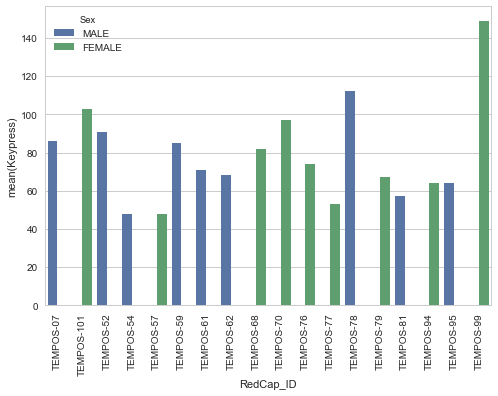

In [175]:
sns.barplot(x="RedCap_ID", y="Keypress", hue="Sex", data=merged_df)
plt.xticks(rotation=90)


###### Preprocessing for Geometric Distribution

Geometric Distribution for p-value and mean and variance and generating the plot of geometric distribution.

In [176]:
df_combine=pd.DataFrame()
df_combine['Doses']=doses
df_combine['Demand']=keypress
df_combine['Gender']=gender
df_combine['Age']=age
df_combine['Service']=service
df_combine['p']=df_combine['Doses']/df_combine['Demand']
df_combine['p'].mean()
df_combine_fil=df_combine[df_combine.Age!='']
p_age=df_combine_fil.groupby('Age')['p'].mean()
p_sex=df_combine_fil.groupby('Gender')['p'].mean()
p_service=df_combine_fil.groupby('Service')['p'].mean()

##### p-values for service ,age ,gender (Geometric Distribution)

In [177]:
p_service_df=pd.DataFrame(p_service)
p=p_service_df['p']
p_service_df['mean']=1/p
p_service_df['variance']= (1-p)/(p*p)
p_service_df

,p,mean,variance
Service,,,
Neurosurgery,0.601236,1.663242,1.103131


In [178]:
p_age_df=pd.DataFrame(p_age)
p=p_age_df['p']
p_age_df['mean']=1/p
p_age_df['variance']= (1-p)/(p*p)
p_age_df

,p,mean,variance
Age,,,
Above 70,0.601236,1.663242,1.103131


In [179]:
p_sex_df=pd.DataFrame(p_sex)
p=p_sex_df['p']
p_sex_df['mean']=1/p
p_sex_df['variance']= (1-p)/(p*p)
p_sex_df

,p,mean,variance
Gender,,,
FEMALE,0.601236,1.663242,1.103131


In [181]:
p=sum(doses)/sum(keypress)
p

0

### Geometric Distribution

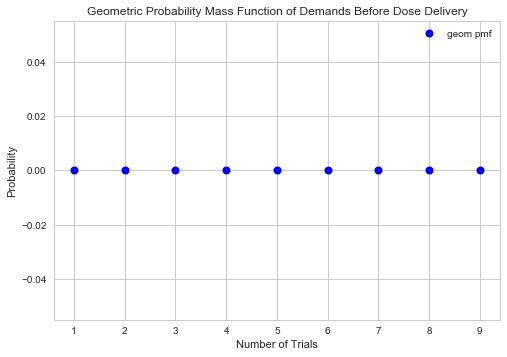

In [182]:
fig, ax = plt.subplots(1, 1)
x = range(1,10)
ax.plot(x, geom.pmf(x, p), 'bo', ms=8, label='geom pmf')
ax.vlines(x, 0, geom.pmf(x, p), colors='b', lw=5, alpha=0.5)
prob = geom.cdf(x, p)
#ax.plot(x,prob)
#rv = geom(p)
#ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
#         label='frozen pmf')
ax.legend(loc='best', frameon=False)

plt.xlabel('Number of Trials')
plt.ylabel('Probability')
plt.title("Geometric Probability Mass Function of Demands Before Dose Delivery")
pp = PdfPages('Fig2.pdf')
pp.savefig(fig,bbox_inches='tight')
pp.close()
plt.show()

#### Preprocessing to get the number of demands/deliveries per day and per hour

In [183]:
#time_demand.remove(519191369.0)
time_demand=np.array(time_demand)
time_demand=time_demand[~np.isnan(time_demand)]
time_delivery=np.array(time_delivery)
time_delivery=time_delivery[~np.isnan(time_delivery)]


In [184]:
min=[]
for i in range(0,200,10) :
        min.append(i)

In [185]:
time_demand=time_demand/(60)

In [186]:
time_delivery=time_delivery/(60)

Number of delivery per hour

In [187]:
delivery_per_hr=[]
delivery_per_hr[:] = [x / (60*60) for x in delivery_hr]
delivery_per_hr=[int(float(x)) for x in delivery_per_hr]

In [188]:
dm_per_hr=pd.DataFrame(delivery_per_hr)
mean_delivery=dm_per_hr.groupby(0).size()

Number of demands per hour

In [189]:
demand_per_hr=[]
demand_per_hr[:] = [x / (60*60) for x in demand_hr]
demand_per_hr=[int(float(x)) for x in demand_per_hr]

In [190]:
dm_per_hr=pd.DataFrame(demand_per_hr)
mean_demand=dm_per_hr.groupby(0).size()

In [191]:
mean_demand_hr=sum(mean_demand)/len(mean_demand)

 Generating the demand and delivery within the first 72 hours. 

In [192]:
dmd_72=mean_demand[0:72]
mean_dmd_72=sum(dmd_72)/len(dmd_72)

In [193]:
demand_per_day=[]
demand_per_day[:] = [x / (60*60*24) for x in demand_hr]

Number of demands per day

In [194]:
demand_per_day=[int(float(x)) for x in demand_per_day]
dm_per_day=pd.DataFrame(demand_per_day)
mean_demand_day=dm_per_day.groupby(0).size()
#mean_dmd_day=sum(mean_demand_day)/len(mean_demand_day)

Number of deliveries per day

In [195]:
delivery_per_day=[]
delivery_per_day[:] = [x / (60*60*24) for x in delivery_hr]
delivery_per_day=[int(float(x)) for x in delivery_per_day]
del_per_day=pd.DataFrame(delivery_per_day)
mean_delivery_day=del_per_day.groupby(0).size()
#mean_delivery_day=sum(mean_delivery_day)/len(mean_delivery_day)

In [196]:
day=[1,2,3,4,5]

In [197]:
df_dem_doses=pd.DataFrame()
df_dem_doses['Day']=day
df_dem_doses['Demand']=mean_demand_day[0:5]
df_dem_doses['Doses']=mean_delivery_day
df_dem_doses['p']=mean_delivery_day/mean_demand_day[0:5]
p=df_dem_doses['p']
df_dem_doses['mean']=1/p
df_dem_doses['variance']= (1-p)/(p*p)
df_dem_doses[['Day','p','mean','variance']]

,Day,p,mean,variance
0,1,0.584283,1.711500,1.217731
1,2,0.644372,1.551899,0.856491
2,3,0.565737,1.767606,1.356824
3,4,0.575758,1.736842,1.279778
4,5,0.666667,1.500000,0.750000


The doses/ demands for postoperative days

In [198]:
df_dem_doses

,Day,Demand,Doses,p,mean,variance
0,1,2545,1487,0.584283,1.711500,1.217731
1,2,613,395,0.644372,1.551899,0.856491
2,3,251,142,0.565737,1.767606,1.356824
3,4,66,38,0.575758,1.736842,1.279778
4,5,18,12,0.666667,1.500000,0.750000


In [199]:
p_arr=mean_delivery_day[0:6]/mean_demand_day[0:6]

In [200]:
mean_delivery_day[0:6]/mean_demand_day[0:6]

0
0    0.584283
1    0.644372
2    0.565737
3    0.575758
4    0.666667
5         NaN
7         NaN
dtype: float64

Geometric Distribution for postoperative days

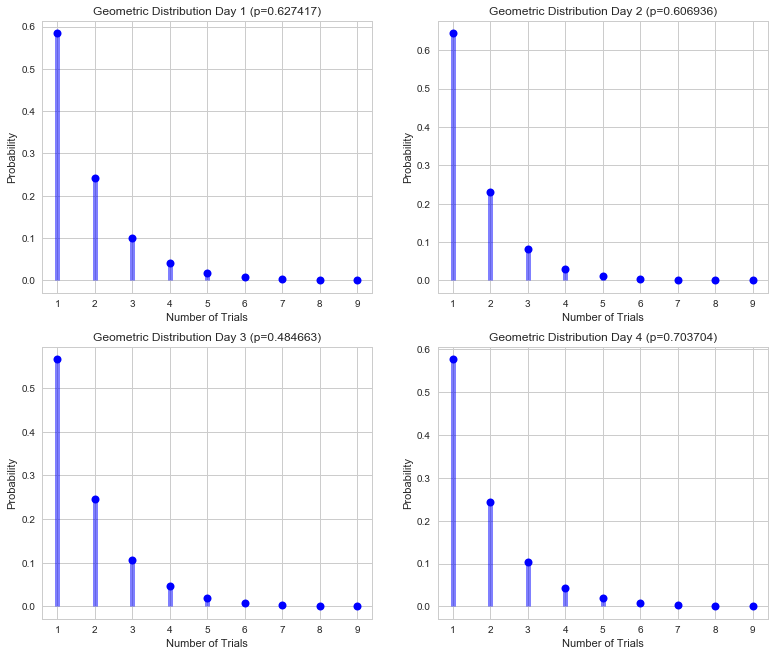

In [201]:
x = range(1,10)
f, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2,figsize=(13,11))

ax1.plot(x, geom.pmf(x, p_arr[0]), 'bo', ms=8, label='geom pmf')
ax1.vlines(x, 0, geom.pmf(x, p_arr[0]), colors='b', lw=5, alpha=0.5)
ax1.set_title('Geometric Distribution Day 1 (p=0.627417)')
ax1.set_ylabel('Probability')
ax1.set_xlabel('Number of Trials')

#plt.title('Day 1.p=',p_arr[0])

ax2.plot(x, geom.pmf(x, p_arr[1]), 'bo', ms=8, label='geom pmf')
ax2.vlines(x, 0, geom.pmf(x, p_arr[1]), colors='b', lw=5, alpha=0.5)
ax2.set_title('Geometric Distribution Day 2 (p=0.606936)')
ax2.set_ylabel('Probability')
ax2.set_xlabel('Number of Trials')

ax3.plot(x, geom.pmf(x, p_arr[2]), 'bo', ms=8, label='geom pmf')
ax3.vlines(x, 0, geom.pmf(x, p_arr[2]), colors='b', lw=5, alpha=0.5)
ax3.set_title('Geometric Distribution Day 3 (p=0.484663)')
ax3.set_ylabel('Probability')
ax3.set_xlabel('Number of Trials')


ax4.plot(x, geom.pmf(x, p_arr[3]), 'bo', ms=8, label='geom pmf')
ax4.vlines(x, 0, geom.pmf(x, p_arr[3]), colors='b', lw=5, alpha=0.5)
ax4.set_title('Geometric Distribution Day 4 (p=0.703704)')
ax4.set_ylabel('Probability')
ax4.set_xlabel('Number of Trials')

#ax.plot(x,prob)
#rv = geom(p)
#ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
#         label='frozen pmf')
pp = PdfPages('Fig2B.pdf')
pp.savefig(f,bbox_inches='tight')
pp.close()
plt.show()

##### Kaplan Meier Plots for last demand and delivery

In [202]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
dff=pd.DataFrame(last_demand)
dff[1]=1
T = dff[0]
E = dff[1]
kmf.fit(T, event_observed=E,label='KM estimate for Demand') # more succiently, kmf.fit(T,E)
kmf.survival_function_
kmf.median_
f=kmf.plot()
pp = PdfPages('IZZA.pdf')
#pp.savefig(kmf,bbox_inches='tight')
pp.close()
plt.show()

ImportError: No module named lifelines

In [203]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
dff=pd.DataFrame(last_delivery)
dff[1]=1
T = dff[0]
E = dff[1]
kmf.fit(T, event_observed=E,label='KM estimate for Delivery') # more succiently, kmf.fit(T,E)
kmf.survival_function_
kmf.median_
f=kmf.plot()
pp = PdfPages('IZZB.pdf')
#pp.savefig(ax,bbox_inches='tight')
pp.close()
plt.show()

ImportError: No module named lifelines

In [204]:
preprocessed.to_csv('C:\Raha\Work\TEMPOS\Dr.Tighe\\preprocessed.csv',index=False)

###### DEMAND 72 hours after ,before surgery

In [205]:
mean_demand_72=sum(demand_72)/len(demand_72)
mean_demand_72

72

In [206]:
mean_doses_72=sum(doses_72)/len(doses_72)
mean_doses_72

43

In [207]:
mean_dem=sum(keypress)/len(patient)
mean_dem

76

In [208]:
mean_doses=sum(doses)/len(patient)
mean_doses

44

In [209]:
p

0    0.584283
1    0.644372
2    0.565737
3    0.575758
4    0.666667
Name: p, dtype: float64

In [210]:
labels=[]
for i in range(1,len(patient)+1):
    string='Patient '+ repr(i)   
    labels.append(string)

### Demands/Deliveries per patients

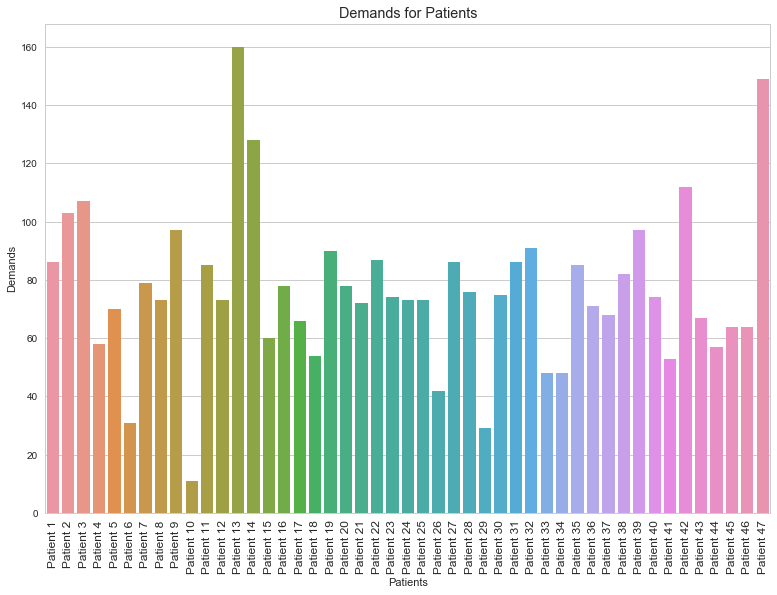

In [211]:
g=sns.barplot(x="RedCap_ID", y="Keypress", data=combined)
g.figure.set_size_inches(13, 9)
g.set(xticklabels=labels)
plt.xticks(rotation=90,fontsize=12)
g.set(xlabel='Patients', ylabel='Demands')
sns.set(font_scale=1.2)
sns.plt.title('Demands for Patients')
f=g.get_figure()
#f.figure(figsize=(13,10))
pp = PdfPages('1A.pdf')
pp.savefig(f,bbox_inches='tight')
pp.close()

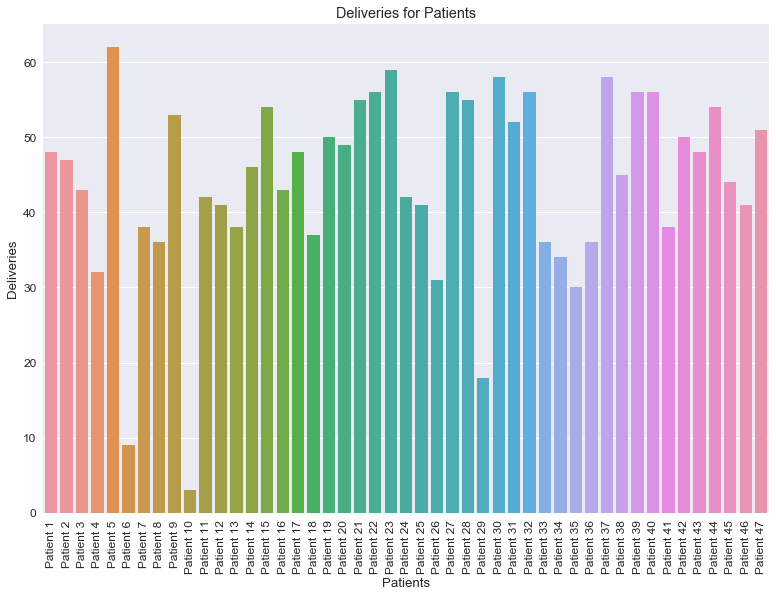

In [212]:
g=sns.barplot(x="RedCap_ID", y="Doses", data=combined)
g.figure.set_size_inches(13, 9)
plt.xticks(rotation=90,fontsize=12)
g.set(xticklabels=labels)
g.set(xlabel='Patients', ylabel='Deliveries')
sns.set(font_scale=1.2)
sns.plt.title('Deliveries for Patients')
f=g.get_figure()
pp = PdfPages('1B.pdf')
pp.savefig(f,bbox_inches='tight')
pp.close()

### Deliveries vs Demands

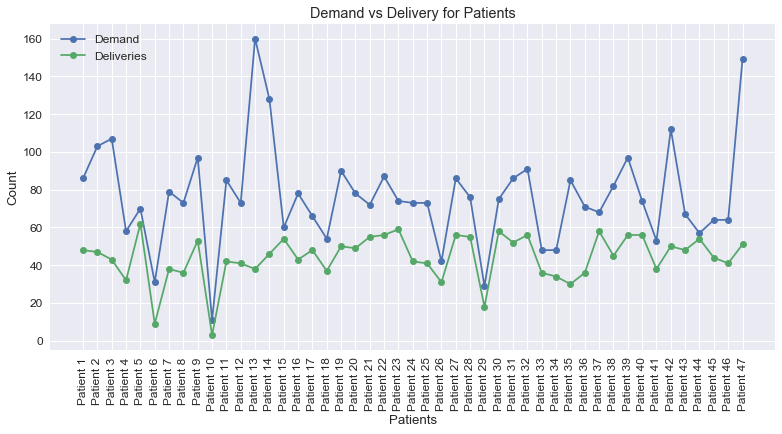

In [213]:
y2=combined['Doses'].tolist()
y1=combined['Keypress'].tolist()
x=np.arange(len(y1))
#labels=merged_df['RedCap_ID'].tolist()
from matplotlib.backends.backend_pdf import PdfPages 
f=plt.figure(figsize=(13,6))
plt.plot(x,y1,'-o')
plt.plot(x,y2,'-o')
plt.xticks(x, labels, rotation='vertical')
plt.xlabel('Patients')
plt.ylabel('Count')
plt.title("Demand vs Delivery for Patients")
leg=['Demand','Deliveries']
plt.legend(leg, loc='best')
pp = PdfPages('Figure1.pdf')
pp.savefig(f,bbox_inches='tight')
pp.close()

In [214]:
import numpy as np
import scipy.stats as stats
import pylab as pl

h = sorted(combined['Keypress'])

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')
pl.title("Distribution of demands")
pl.xlabel('Patients')
pl.ylabel('Frequency')
pl.hist(h,normed=True)      #use this to draw histogram of your data
#pp = PdfPages('Fig1Demands.pdf')
pl.savefig('Fig1Demands.pdf',bbox_inches='tight')
pl.close()
#pl.xticks(labels)
pl.show() 

In [215]:
import numpy as np
import scipy.stats as stats
import pylab as pl

h = sorted(combined['Doses'])

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')
pl.title("Distribution of deliveries")
pl.xlabel('Patients')
pl.ylabel('Frequency')
pl.hist(h,normed=True)      #use this to draw histogram of your data
pl.savefig('Fig1Deliveries.pdf',bbox_inches='tight')
pl.close()
#pl.xticks(labels)
pl.show() 
pl.show() 

In [216]:
np.mean(keypress)

76.38297872340425

##### DISTRIBUTION OF TIME BETWEEN DEMANDS AND DELIVERIES

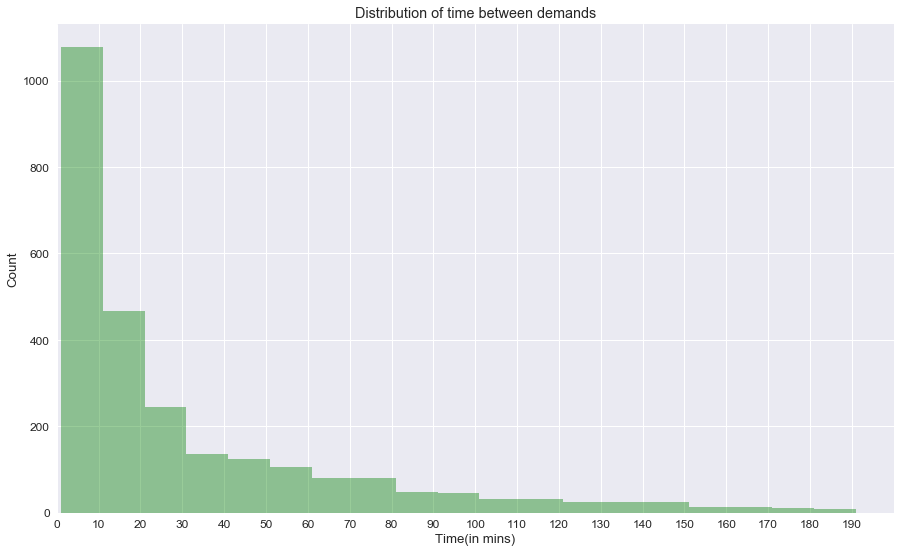

In [217]:
fig, ax = plt.subplots(figsize=(15,9))
sns.distplot(time_demand,bins=range(1, 200,10),kde=False,color='g')
#sns.distplot(time_delivery,bins=range(1, 10000,700),kde=False)
ax.set_xlim([0, 200])
plt.xlabel('Time(in mins)')
plt.xticks(min)
plt.ylabel('Count')
plt.title("Distribution of time between demands")
pp = PdfPages('3A.pdf')
pp.savefig(fig,bbox_inches='tight')
pp.close()

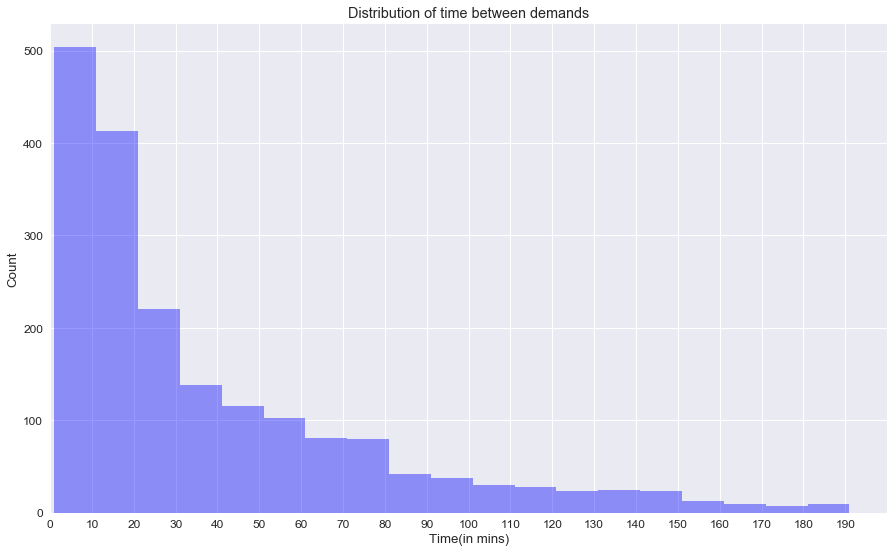

In [218]:
fig, ax = plt.subplots(figsize=(15,9))

sns.distplot(time_delivery,bins=range(1, 200,10),kde=False,color='b')
#sns.distplot(time_delivery,bins=range(1, 10000,700),kde=False)
ax.set_xlim([0, 200])
plt.xlabel('Time(in mins)')
plt.xticks(min)
plt.ylabel('Count')
plt.title("Distribution of time between demands")
pp = PdfPages('3B.pdf')
pp.savefig(fig,bbox_inches='tight')
pp.close()

### Demands  per hour and per day

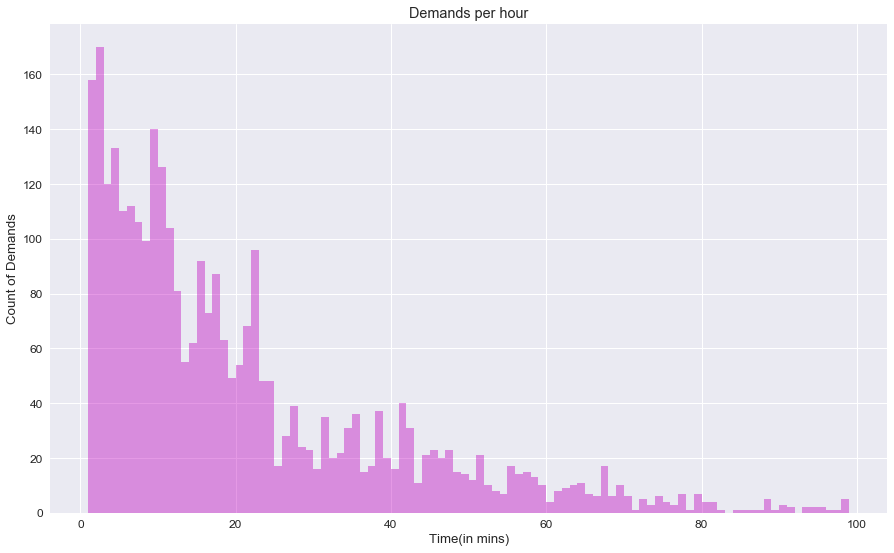

In [219]:
fig=plt.figure(figsize=(15,9))
sns.distplot(demand_per_hr,bins=range(1, 100,1),kde=False,color='m')
ax.set_xlim([0, 100])
plt.xlabel('Time(in mins)')
#plt.xticks(min)
plt.ylabel('Count of Demands')
plt.title("Demands per hour")
pp = PdfPages('1YA.pdf')
pp.savefig(fig,bbox_inches='tight')
pp.close()


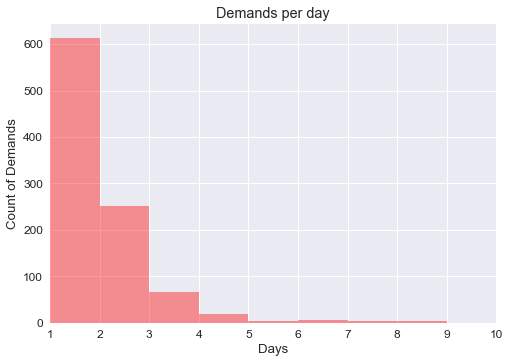

In [220]:
fig, ax = plt.subplots()
sns.distplot(demand_per_day,bins=range(1, 10,1),kde=False,color='r')
#sns.distplot(time_delivery,bins=range(1, 10000,700),kde=False)
ax.set_xlim([1, 10])
plt.xlabel('Days')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.ylabel('Count of Demands')
plt.title("Demands per day")
pp = PdfPages('1YB.pdf')
pp.savefig(fig,bbox_inches='tight')
pp.close()

### Exponential Distribution for demands and deliveries (pdf and cdf)

In [221]:
import scipy.stats as scp
def exponen_dist_pdf(distri,pltname,pdfName,clr):
    fig=plt.figure()
    loc1,scale1=scp.expon.fit(distri)
    x1=np.linspace(0,500,10)
    y1=scp.expon.pdf(x1,loc1,scale1)
    neg_log=-np.sum(scp.expon.logpdf(distri, loc1, scale1))
    logLik=-neg_log
    k=2
    aic=2*k - 2*(logLik)
    print("AIC",aic)
    print("Negative log likelihood",neg_log)
    print("mean",scp.expon.mean(loc1, scale1))
    print("Var",scp.expon.var(loc1, scale1))
    plt.plot (x1,y1,clr)
    plt.xlabel('Time (mins)')
    plt.ylabel('Density')
    plt.title(pltname)
    print(pdfName)
    pp = PdfPages(pdfName+'.pdf')
    pp.savefig(fig,bbox_inches='tight')
    pp.close()
    plt.show()

In [222]:
import scipy.stats as scp
def exponen_dist_cdf(distri,pltname,pdfName,clr):
    loc,scale=scp.expon.fit(distri)
    x=np.linspace(0,500,10)
    y=scp.expon.cdf(x,loc,scale)
    plt.plot (x,y,clr)
    plt.xlabel('Time (mins)')
    plt.ylabel('Density')
    plt.title(pltname)
    print(pdfName)
    pp = PdfPages(pdfName)
    pp.savefig(fig,bbox_inches='tight')
    pp.close()
    plt.show()

('AIC', 33841.757716429391)
('Negative log likelihood', 16918.878858214695)
('mean', 46.41981463627809)
('Var', 2154.7991968136098)
3Aexp


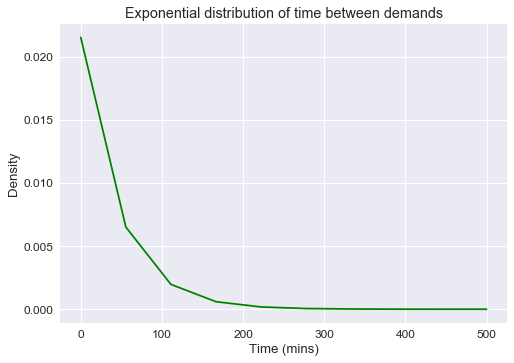

('AIC', 20938.216407242988)
('Negative log likelihood', 10467.108203621494)
('mean', 64.187656799316315)
('Var', 4115.7772194677455)
3Bexp


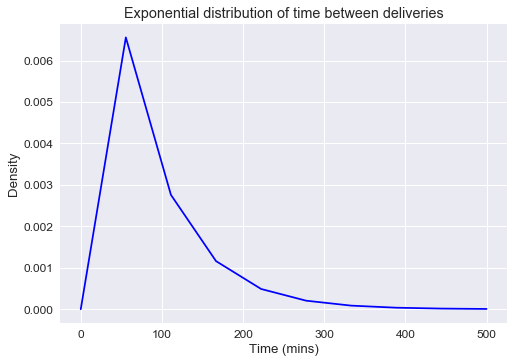

In [224]:
exponen_dist_pdf(time_demand,'Exponential distribution of time between demands','3Aexp','g')
exponen_dist_pdf(time_delivery,'Exponential distribution of time between deliveries','3Bexp','b')

# Exponential Distribution of Demand by Age Sex nd Service  

In [225]:
time_demand_df=time_demand_df[(time_demand_df[0]!=519191369.0/60)]

In [226]:
time_demand_df=time_demand_df[time_demand_df[0]==519191369.0]
time_demand_df=time_demand_df.dropna(how='any')
time_demand_df[0]=time_demand_df[0]/60
time_delivery_df=time_delivery_df.dropna(how='any')
time_delivery_df[0]=time_delivery_df[0]/60


In [227]:
def expMeanVar(distr,st):
    loc1,scale1=scp.expon.fit(distr)
    print(st)
    print("mean",scp.expon.mean(loc1, scale1))
    print("Var",scp.expon.var(loc1, scale1))

In [228]:
sex_list=time_delivery_df['Sex'].unique()
age_list=time_delivery_df['Age'].unique()
service_list=time_delivery_df['Service'].unique()
for sx in sex_list:
    sx_list=time_delivery_df[0][time_delivery_df['Sex']==sx]
    expMeanVar(sx_list,sx)
for ag in age_list:
    age_list=time_delivery_df[0][time_delivery_df['Age']==ag]
    expMeanVar(age_list,ag)
for sr in service_list:
    sr_list=time_delivery_df[0][time_delivery_df['Service']==sr]
    expMeanVar(sr_list,sr)
expMeanVar(time_delivery_df[0],"All")
  

FEMALE
('mean', 64.187656799316315)
('Var', 4115.7772194677455)
Above 70
('mean', 64.187656799316315)
('Var', 4115.7772194677455)
Neurosurgery
('mean', 64.187656799316315)
('Var', 4115.7772194677455)
All
('mean', 64.187656799316315)
('Var', 4115.7772194677455)


##### DEMAND VS DELIVERY

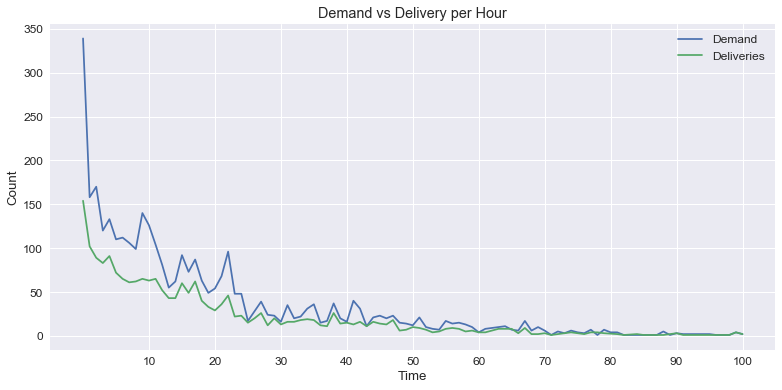

In [229]:
mean_demand_pd=pd.DataFrame(mean_demand[0:100])
mean_delivery_pd=pd.DataFrame(mean_delivery)

mean_demand_pd.columns=['dmd']
mean_delivery_pd.columns=['del']
mean_demand_pd=mean_demand_pd.reset_index()
mean_demand_pd=mean_demand_pd[mean_demand_pd[0]<=100]

mean_delivery_pd=mean_delivery_pd.reset_index()
mean_delivery_pd=mean_delivery_pd[mean_delivery_pd[0]<=100]
y1=mean_demand_pd['dmd'].tolist()
y2=mean_delivery_pd['del'].tolist()
x1=mean_demand_pd[0].tolist()
x2=mean_delivery_pd[0].tolist()
#labels=merged_df['RedCap_ID'].tolist()
from matplotlib.backends.backend_pdf import PdfPages 
f=plt.figure(figsize=(13,6))
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.xticks([10,20,30,40,50,60,70,80,90,100])
plt.xlabel('Time')
plt.ylabel('Count')
plt.title("Demand vs Delivery per Hour")
leg=['Demand','Deliveries']
plt.legend(leg, loc='best')
pp = PdfPages('Fig1Z.pdf')
pp.savefig(f,bbox_inches='tight')
pp.close()
plt.show()

In [230]:
time_delivery_df=time_delivery_df.dropna(how='any')

In [231]:
exp_dmd=pd.DataFrame()
sex_list=time_demand_df['Sex'].unique()
age_list=time_demand_df['Age'].unique()
service_list=time_demand_df['Service'].unique()
for sx in sex_list:
    sx_list=time_demand_df[0][time_demand_df['Sex']==sx]
    expMeanVar(sx_list,sx)
for ag in age_list:
    age_list=time_demand_df[0][time_demand_df['Age']==ag]
    expMeanVar(age_list,ag)
for sr in service_list:
    sr_list=time_demand_df[0][time_demand_df['Service']==sr]
    expMeanVar(sr_list,sr)
expMeanVar(time_demand_df[0],"All")
  

FEMALE
('mean', 8653189.4833333381)
('Var', 2.1778287899632969e-17)
Above 70
('mean', 8653189.4833333381)
('Var', 2.1778287899632969e-17)
Neurosurgery
('mean', 8653189.4833333381)
('Var', 2.1778287899632969e-17)
All
('mean', 8653189.4833333381)
('Var', 2.1778287899632969e-17)


### Poisson Distribution

C:\Users\BME-LADM-Baharloo\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\cbook.py:2649: UserWarning: Saw kwargs [u'ls', u'linestyle'] which are all aliases for u'linestyle'.  Kept value from u'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


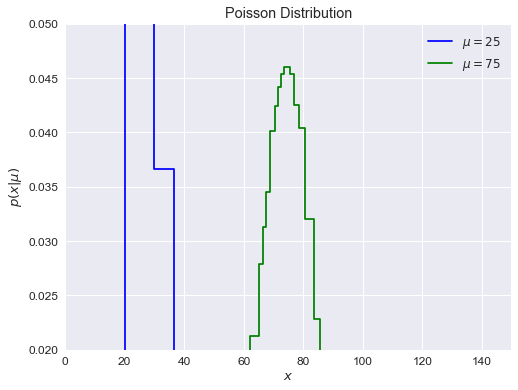

In [232]:
from scipy.stats import poisson
import matplotlib.pyplot as plt
mu_values = [25,75]
linestyles = [ '-', '-']
colors=['blue','green']
#------------------------------------------------------------
# plot the distributions
#   we generate it using scipy.stats.poisson().  Once the distribution
#   object is created, we have many options: for example
#   - dist.pmf(x) evaluates the probability mass function in the case of
#     discrete distributions.
#   - dist.pdf(x) evaluates the probability density function for
#   evaluates
fig, ax = plt.subplots(figsize=(8, 6))

for mu, ls,c in zip(mu_values, linestyles,colors):
    # create a poisson distribution
    # we could generate a random sample from this distribution using, e.g.
    #   rand = dist.rvs(1000)
    dist = poisson(mu)
    x = np.sort(keypress)
    
    plt.plot(x, dist.pmf(x), ls=ls, color=c,
             label=r'$\mu=%i$' % mu, linestyle='steps-mid')

plt.xlim(0, 150)
plt.ylim(0.02, 0.05)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu)$')
plt.title('Poisson Distribution')

plt.legend()
plt.show()

pp = PdfPages('Poisson.pdf')
pp.savefig(fig,bbox_inches='tight')
pp.close()